# Demodulación con tralapamiento de 15GHz usando KNN y SVM

In [233]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
import warnings
from numpy import pi
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sofa_sem import *

In [234]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [235]:
SNR = [23, 25, 27, 30, 32, 35, 40]
df = pd.DataFrame()
for i in SNR:
    if (i == 32) or (i == 40) or (i == 27):
        rot = 3 * pi / 2
    elif (i == 30):
        rot = 0
    elif (i == 35):
        rot = pi / 2
    else:
        rot = pi
    data_rx = sio.loadmat(f'Distances\\15GHz\\16QAM_3x16GBd_consY{i}dB.mat')
    data_rx = 3 * (data_rx['const_Y'] - data_rx['const_Y'].mean()) / data_rx['const_Y'].std()
    df[f'Rx_{i}dB'] = np.transpose(data_rx * np.exp(1j * rot)).flatten()
df.head()

,Rx_23dB,Rx_25dB,Rx_27dB,Rx_30dB,Rx_32dB,Rx_35dB,Rx_40dB
0,-1.968743+2.356595j,2.576490-3.260630j,1.701967+2.719061j,-3.075793+2.911497j,3.042746-3.207428j,1.103566-0.242777j,-2.331011+1.744516j
1,2.446054+2.626786j,3.597607-1.521705j,-0.820573+0.553303j,-1.998239+2.676509j,-0.678744+1.172166j,-1.456300+0.424859j,-1.312772+3.336845j
2,-0.571291-2.120426j,2.329450+1.029816j,-0.472305+2.822748j,2.105724+0.695163j,-1.356719-0.664171j,-2.546041-0.297985j,-1.013831-1.688941j
3,-1.905965-2.763917j,0.932853+0.667817j,1.792871+0.121434j,-1.136930+2.783792j,-0.501647-1.189905j,0.830728-1.734157j,0.998378+2.981686j
4,-0.130414+2.440278j,3.138558+0.778352j,0.463329-2.446709j,0.184319-2.196407j,-1.893946-2.826547j,-2.662497-1.778204j,0.708215+2.527684j


In [236]:
# Datos experimentales transmitidos (Tx)
data_tx = sio.loadmat('Distances\\2x16QAM_16GBd.mat')
data_tx = data_tx['Constellation'].flatten()[0][0]
df_tx = pd.DataFrame(np.transpose(data_tx), columns = ['Tx'])
df_tx.head()

,Tx
0,3.0+3.0j
1,-3.0-3.0j
2,3.0-1.0j
3,-3.0+3.0j
4,-3.0+3.0j


In [237]:
sync_tx = [sync_signals(df_tx['Tx'], df[f'Rx_{i}dB']) for i in SNR]

In [238]:
y = [demodulate(sync_tx[i]) for i in range(len(SNR))]

## Preparación de los datos

In [239]:
Xr = [np.real(df[f'Rx_{i}dB']) for i in SNR]
Xi = [np.imag(df[f'Rx_{i}dB']) for i in SNR]

In [240]:
X = [np.transpose(np.array([Xr[i], Xi[i]])) for i in range(len(SNR))]

## Método convencional

In [241]:

# Se demapean los datos extraidos del canal con ruido
sym_rx = [demapper_sym(Xr[i], Xi[i], len(Xr[i]), threshold = 2.0) for i in range(len(SNR))]

In [242]:
ber_conventional = []
for i in range(len(SNR)):
  ber, ber_error = bit_error_rate(y[i], sym_rx[i])
  ber_conventional.append(ber)

## Modelo KNN

In [243]:
ber_knn = []
for it in range(len(SNR)):
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X[it], y[it], test_size=0.4)

    # Instanciar el modelo k-NN
    model = KNeighborsClassifier(n_neighbors=5)

    # Entrenar el modelo con los datos de entrenamiento
    model.fit(X_train, y_train)

    # Calcular la precisión del modelo en los datos de prueba
    y_pred = model.predict(X_test)
    #print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

    # Calcular Tasa de Error de Bit
    ber, ber_error = bit_error_rate(y_test, y_pred)
    ber_knn.append(ber)

## Modelo SVM

In [244]:
ber_svm = []
for it in range(len(SNR)):
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X[it], y[it], test_size=0.4)

    # Instanciar el modelo SVC
    model = SVC()

    # Entrenar el modelo con los datos de entrenamiento
    model.fit(X_train, y_train)

    # Calcular la precisión del modelo en los datos de prueba
    y_pred = model.predict(X_test)
    #print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

    # Calcular Tasa de Error de Bit
    ber, ber_error = bit_error_rate(y_test, y_pred)
    ber_svm.append(ber)

## Arboles de decisión

In [245]:
ber_tree = []
for it in range(len(SNR)):
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X[it], y[it], test_size=0.4)

    # Instanciar el modelo de arboles de decisión
    model = DecisionTreeClassifier()

    # Entrenar el modelo con los datos de entrenamiento
    model.fit(X_train, y_train)

    # Calcular la precisión del modelo en los datos de prueba
    y_pred = model.predict(X_test)
    #print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

    # Calcular Tasa de Error de Bit
    ber, ber_error = bit_error_rate(y_test, y_pred)
    ber_tree.append(ber)

## Comparación entre los modelos

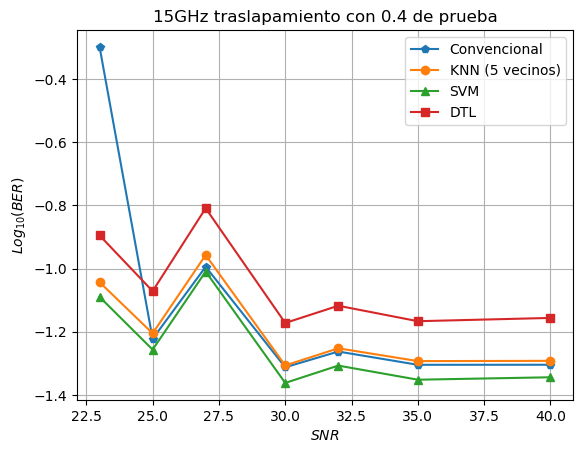

In [246]:
plt.plot(SNR, np.log10(ber_conventional), marker='p', label='Convencional')
plt.plot(SNR, np.log10(ber_knn), marker='o', label='KNN (5 vecinos)')
plt.plot(SNR, np.log10(ber_svm), marker='^', label='SVM')
plt.plot(SNR, np.log10(ber_tree), marker='s', label='DTL')
plt.title('15GHz traslapamiento con 0.4 de prueba')
plt.xlabel('$SNR$')
plt.ylabel('$Log_{10}(BER)$')
plt.legend()
plt.grid()
plt.show()